In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
#merge customer and transaction data
customer_transactions = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",   # Total money spent
    "TransactionID": "count",  # Number of transactions
    "TransactionDate": "max"  # Most recent transaction
}).reset_index()

In [4]:
merge_df = pd.merge(customers, customer_transactions, on="CustomerID", how="inner")

In [5]:
merge_df["SignupDate"] = pd.to_datetime(merge_df["SignupDate"])
merge_df["TransactionDate"] = pd.to_datetime(merge_df["TransactionDate"])

In [6]:
#feature engineering
current_date = merge_df["TransactionDate"].max()
merge_df["Recency"] = (current_date - merge_df["TransactionDate"]).dt.days  #days since last transaction
merge_df.drop(columns=["TransactionDate", "SignupDate", "CustomerName"], inplace=True)

In [7]:
label_encoder = LabelEncoder()
merge_df["Region"] = label_encoder.fit_transform(merge_df["Region"])

In [8]:
scaler = StandardScaler()
numeric_features = ["TotalValue", "TransactionID", "Recency"]
data_scaled = scaler.fit_transform(merge_df[numeric_features])

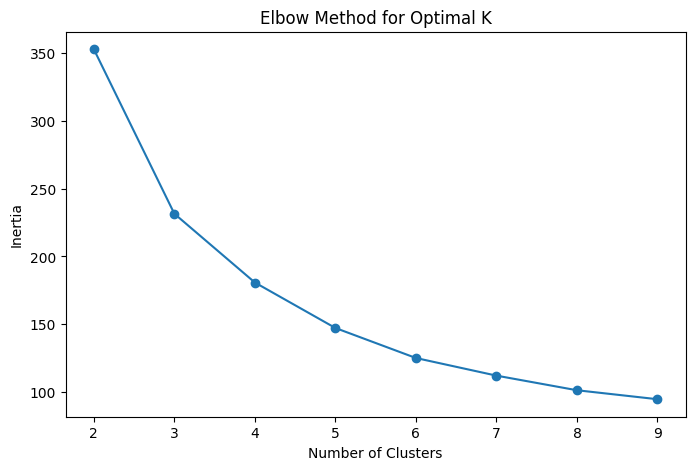

In [9]:
#determine the optimal number of clusters (Elbow Method)
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

In [10]:
#KMeans with optimal K (let K=4 based on Elbow Method)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
merge_df["Cluster"] = kmeans.fit_predict(data_scaled)

In [11]:
#evaluate clustering
db_index = davies_bouldin_score(data_scaled, merge_df["Cluster"])
silhouette_avg = silhouette_score(data_scaled, merge_df["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Davies-Bouldin Index: 1.0185
Silhouette Score: 0.3103


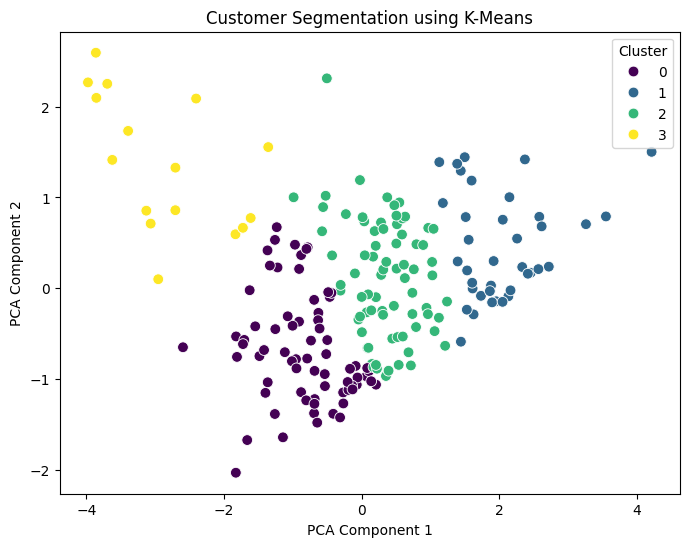

In [12]:
#visualization using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
merge_df["PCA1"] = data_pca[:, 0]
merge_df["PCA2"] = data_pca[:, 1]
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=merge_df["Cluster"], palette="viridis", data=merge_df, s=60)
plt.title("Customer Segmentation using K-Means")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()